# Integrating Speech Recognition and Machine Learning


## Summary
This notebook presents a workflow for transcribing audio files using OpenAI's Whisper model. Whisper is a state-of-the-art speech recognition system designed to handle a wide range of audio types and accents. It is highly effective for converting spoken language in audio files into written text.

The workflow includes steps for using Whisper to transcribe audio files, processing them efficiently, and storing the transcriptions in a structured format for further analysis or use. This can be particularly useful for tasks such as generating subtitles, transcribing meetings, or converting speech from various audio sources into text for machine learning. 

In this example, we will be taking the transcribed data and building a classification model DataRobot. DataRobot will be used for the model training, selection, deployment, and evaluating data for insights.


This notebook will demonstrate how to use the Python API client to:


1.  Setting up the environment: Install and import necessary libraries including Whisper and dependencies
2.  Securely Connect to DataRobot
3.  Get data (publicly available audio files in this case)
4.  Transcibe Audio with Whisper: Utilize the Whisper model to transcribe audio files
5.  Use the transcribed text to create a classifciation model in DataRobot
6.  Retrieve and evaluate model performance and insights

## Install [Whisper](https://github.com/openai/whisper)

In [ ]:
pip install openai-whisper

## Install or update FFmpeg
- Whisper also requires [FFmpeg](https://ffmpeg.org/), an audio-processing library. If FFmpeg is not already installed on your machine, use one of the below commands to install it.
- The MacOS installation command requires Homebrew, and the Windows installation command requires Chocolatey, so make sure to install either tool as needed.

Linux - sudo apt update && sudo apt install ffmpeg

MacOS - brew install ffmpeg

Windows - chco install ffmpeg

## Imports

In [1]:
import datetime
import os
import warnings

from colour import Color
import datarobot as dr
from datarobot.errors import ClientError
from datarobot_bp_workshop import Visualize
import matplotlib.pyplot as plt
import pandas as pd
import whisper
from wordcloud import WordCloud

# Suppress the specific FP16 warning
warnings.filterwarnings(
    "ignore", message="FP16 is not supported on CPU; using FP32 instead"
)

# # Adjust output display width
pd.set_option("display.max_colwidth", 150)

## Get Data
In this example we will be working with the [VoxCeleb dataset](https://www.robots.ox.ac.uk/~vgg/data/voxceleb/) (7000+ unique speakers and utterances, 3683 males / 2312 females). The VoxCeleb is an audio-visual dataset consisting of short clips of human speech, extracted from interview videos uploaded to YouTube. VoxCeleb contains speech from speakers spanning a wide range of different ethnicities, accents, professions, and ages.

Here is a [direct link to the files organized by gender used in this example](https://s3.amazonaws.com/datarobot_public_datasets/ai_accelerators/speech_recognition/Data.zip)

** If you'd like to save time and just look at the result of the transcription, you can skip the step of downloading the raw data and the transcription result will be provided below. 

## Functions to transcribe audio files
- The transcribe_file function handles the transcription of individual audio files
- The process_folder function goes through each file in a given folder and compiles the necessary information.

In [2]:
def transcribe_file(model, file_path):
    """
    Transcribes a given audio file using the Whisper model.
    """
    try:
        result = model.transcribe(file_path)
        return result["text"], result["language"]
    except Exception as e:
        print(f"Error transcribing file {file_path}: {e}")
        return "", "Unknown"


def process_folder(folder_path, gender):
    """
    Processes each audio file in the folder and returns a list of dictionaries
    containing folder name, file name, transcription, and detected language.
    Also prints out detailed information for each file being processed.
    """
    data = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".m4a"):
            file_path = os.path.join(folder_path, filename)
            transcription, language = transcribe_file(model, file_path)
            print(
                f"Filename: {filename} | Gender: {gender} | Language: {language} | Transcription: {transcription[:50]}..."
            )
            data.append(
                {
                    "Gender": gender,
                    "Filename": filename,
                    "Transcription": transcription,
                    "Language": language,
                }
            )
    return data

## Transcribe a single audio file

In [3]:
# Load Whisper model
model = whisper.load_model("base")

# Define the path to your specific audio file
# Replace 'path/to/your/audio/file.m4a' with your actual file path
file_path = "Data/VoxCeleb_gender/females/2296.m4a"

# Transcribe the audio file
transcription, language = transcribe_file(model, file_path)

# Print the transcription and language
print(f"Transcription: {transcription}")
print(f"Language: {language}")

Transcription:  And from there I've kind of been digging around and finding more things that in the electronic
Language: en


## Load whisper model and process ALL audio files

There are five model sizes, four with English-only versions, offering speed and accuracy tradeoffs (tiny, base, small, medium, and large). Each version has its own memory requirements and inference speed relative to the large model; actual speed may vary depending on many factors including the available hardware.

This script assumes that the "base" Whisper model is sufficient for your needs

Validate the file paths are correct. In this example, "VoxCeleb/males" and "VoxCeleb/females" are correctly specified in the directory structure

In [5]:
# Load Whisper model
model = whisper.load_model("base")

# Initialize data list
data = []

# Process each folder
data.extend(process_folder("Data/VoxCeleb_gender/males", "Male"))
data.extend(process_folder("Data/VoxCeleb_gender/females", "Female"))

# Create DataFrame
df = pd.DataFrame(data)

Filename: 0.m4a | Gender: Female | Language: hi | Transcription:  Galaxy, all this is a dilemma for me......
Filename: 2.m4a | Gender: Female | Language: en | Transcription:  It was more opportunity for me here to progress a...
Filename: 3.m4a | Gender: Female | Language: id | Transcription:  Karena oh ya sudah gitu, akhirnya itu totok, 10 m...
Filename: 7.m4a | Gender: Female | Language: ar | Transcription:  النهو ، ما jeinst กطو the invention of the Z kons...
Filename: 4.m4a | Gender: Female | Language: en | Transcription:  It was because the rest of the film, I mean the s...


## Preview the transcription data

In [6]:
# OPTIONAL - if you skipped the transcription step you can read in this csv data into a dataframe
df = pd.read_csv(
    "https://s3.amazonaws.com/datarobot_public_datasets/ai_accelerators/speech_recognition/Data/VoxCeleb_gender_Whisper_base_transcriptions.csv"
)

# Preview the transcribed data
df

,Unnamed: 0,Gender,Filename,Transcription,Language
0,0,Male,1975.m4a,"Zrobiliśmy kawał dobrej roboty. Bo to jest zespół, bo mam świetnych mechaników, mam pilota, bo są ci wszyscy ludzie, którzy tworzą to coś. I to j...",pl
1,1,Male,239.m4a,"cuando jugamos a fuera, es muy fuerte, esperamos que mañana los vamos.",es
2,2,Male,1961.m4a,"There was high effort, high energy, and taking the football, which was exciting to see.",en
3,3,Male,1949.m4a,It's when I die I'm to be cremated and the ashes are to be thrown in Rick Perry's hay.,en
4,4,Male,205.m4a,"Poco un amor, Dios. Parece que te tiene miedo enganchado de golpe y te ya no quiero ver más, pero ahora voy a postear una foto.",es
...,...,...,...,...,...
5988,5988,Female,234.m4a,It's like it made me my resume. So they used to want us to try to vamp up your resume so that add different interesting special skills.,en
5989,5989,Female,1978.m4a,I'm a player from Israel. I'm 25 years old and I'm a professional tennis player.,en
5990,5990,Female,552.m4a,He's making no apologies for the strategy he's chosen to combat ISIS.,en
5991,5991,Female,546.m4a,"painters, poets, whatever. It's a great reference book and tool for them. So for him, he said this was...",en


In [46]:
# Let's look at the count of transcriptions by gender and language

# Create a crosstab
crosstab = pd.crosstab(df["Language"], df["Gender"], margins=True, margins_name="Total")

# Display the crosstab
crosstab

Gender,Female,Male,Total
Language,,,
ar,11,15,26
bg,1,2,3
bn,3,3,6
bs,4,4,8
ca,4,11,15
...,...,...,...
vi,2,5,7
yi,0,1,1
yo,0,6,6


## Connect to DataRobot
To connect to DataRobot, you need to provide your API token and the endpoint. For more information, please refer to the following documentation:

 - [Create and manage API keys via developer tools in the GUI](https://docs.datarobot.com/en/docs/platform/account-mgmt/acct-settings/api-key-mgmt.html#api-key-management)
 - [Different options to connect to DataRobot from the API client](https://docs.datarobot.com/en/docs/api/api-quickstart/index.html)
   
Your API token can be found in the DataRobot UI in the Developer tools section, accessed from the profile menu in the top right corner. Copy the API token and paste in the cell below.

In [2]:
# Instantiate the DataRobot connection

# Get the token from the Developer Tools page in the DataRobot UI
DATAROBOT_API_TOKEN = ""

# Endpoint - This notebook uses the default endpoint for DataRobot Managed AI Cloud (US)
DATAROBOT_ENDPOINT = "https://app.datarobot.com/api/v2/"  # This should be the URL you use to access the DataRobot UI

dr.Client(token=DATAROBOT_API_TOKEN, endpoint=DATAROBOT_ENDPOINT)

## Create a classification project in DataRobot to predict gender
DataRobot will leverage the transcribed text from Whisper to determine if we can use it to accurately predict gender.

The majority of the [DataRobot AI platform](https://www.datarobot.com/platform/) models support text data right out of the box. If a particular combination of words or characters in the text is highly related to the target variable, DataRobot automatically captures the pattern and displays it along with other insights. DataRobot is also multilingual, using automatic language identification for text data and supporting different text mining algorithms, depending on the language it detects.

The process of feature engineering free text data in the traditional way is notoriously complex and difficult, and data scientists often avoid doing it manually. DataRobot automatically finds, tunes, and interprets the best text mining algorithms for a dataset, saving both time and resources.

In [52]:
# Create a project by uploading data. This will take a few minutes.
project = dr.Project.create(
    sourcedata=df,
    project_name="Gender_Classification_Model_{}".format(
        datetime.datetime.now().strftime("%Y-%m-%d %H:%M")
    ),
)

# Set the project's target and initiate Autopilot in Quick mode.
# Wait for Autopilot to finish. You can set verbosity to 0 if you do not wish to see progress updates.
project.analyze_and_model(target="Gender", worker_count=-1)

# Open the project's Leaderboard to monitor the progress in UI.
project.open_in_browser()

## Get a model from DataRobot project

In [5]:
models = project.get_models()

top_model = models[0]

# Quick link to the recommended model built by Autopilot
print("Top Model URL: " + top_model.get_uri())
print("Top Model Type: " + top_model.model_type)

Top Model URL: https://app.datarobot.com/projects/65a451671c0450c8cc6c779c/models/65a456016f47c46d6b14cba6
Top Model Type: Elastic-Net Classifier (L2 / Binomial Deviance)


## Display DataRobot Model Blueprint
[DataRobot Blueprints](https://docs.datarobot.com/en/docs/modeling/analyze-models/describe/blueprints.html) are ML pipelines containing preprocessing steps, modeling algorithms, and post-processing steps.

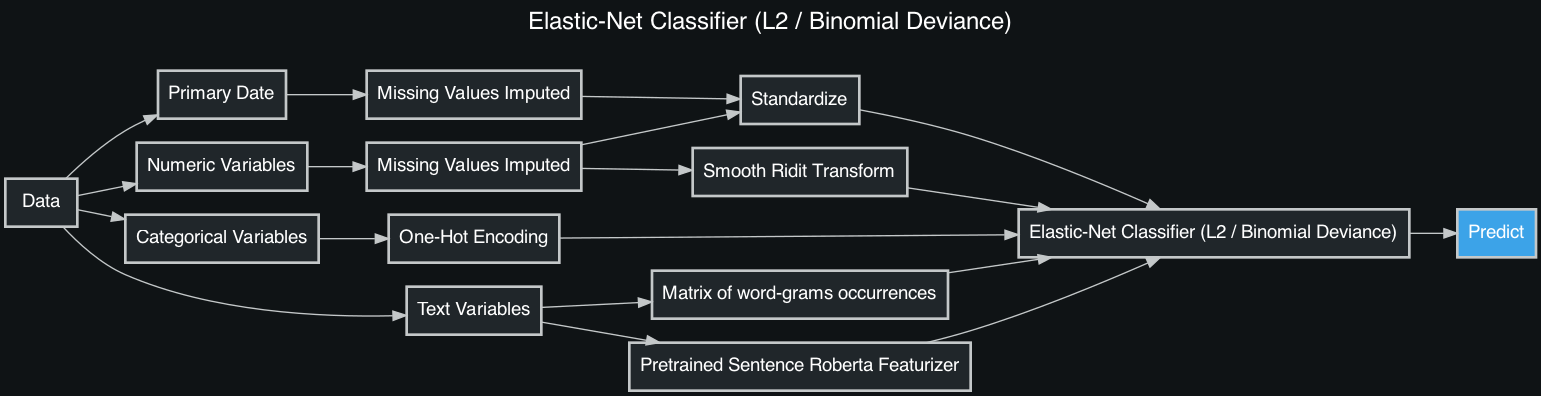

In [6]:
blueprint_id = top_model.blueprint_id
Visualize.show_dr_blueprint(dr.Blueprint.get(project.id, blueprint_id))

## Evaluate [Feature Impact](https://docs.datarobot.com/en/docs/modeling/analyze-models/understand/feature-impact.html)
Feature Impact shows, at a high level, which features are driving model decisions the most. By understanding which features are important to model outcome, you can more easily validate if the model complies with business rules.

In [57]:
# Get Feature Impact
feature_impact = top_model.get_or_request_feature_impact()

# Save feature impact in pandas dataframe
fi_df = pd.DataFrame(feature_impact)
fi_df

,featureName,impactNormalized,impactUnnormalized,redundantWith
0,Transcription,1.000000,0.138095,None
1,Language,0.077909,0.010759,None


## Look at model accuracy metrics

In [25]:
print(
    "Top Model AUC performance (Cross Validation): "
    + str(top_model.metrics["AUC"]["crossValidation"])
)
print(
    "Top Model LogLoss performance (Cross Validation): "
    + str(top_model.metrics["LogLoss"]["crossValidation"])
)

Top Model AUC performance (Cross Validation): 0.672528
Top Model LogLoss performance (Cross Validation): 0.6200640000000001


## Evaluate model accuracy with a [ROC curve](https://docs.datarobot.com/en/docs/modeling/analyze-models/evaluate/roc-curve-tab/roc-curve.html#roc-curve)
The ROC curve visualization helps you explore classification, performance, and statistics for a selected model. ROC curves plot the true positive rate against the false positive rate for a given data source.

(0.0, 1.0)

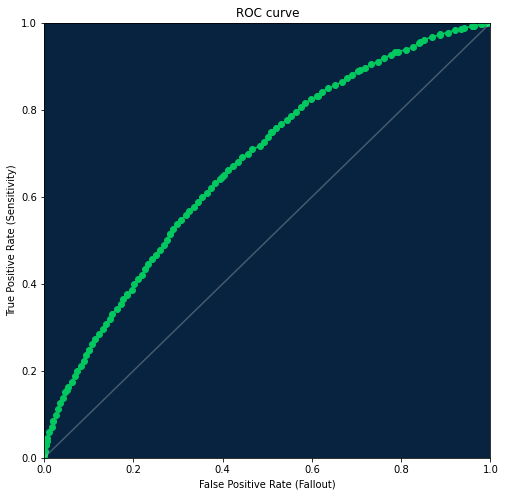

In [62]:
roc = top_model.get_roc_curve("crossValidation")

# Save the result into a pandas dataframe
df = pd.DataFrame(roc.roc_points)

# Plot the ROC curve
dr_roc_green = "#03c75f"
white = "#ffffff"
dr_purple = "#65147D"
dr_dense_green = "#018f4f"
dr_dark_blue = "#08233F"

fig = plt.figure(figsize=(8, 8))
axes = fig.add_subplot(1, 1, 1, facecolor=dr_dark_blue)

plt.scatter(df.false_positive_rate, df.true_positive_rate, color=dr_roc_green)
plt.plot(df.false_positive_rate, df.true_positive_rate, color=dr_roc_green)
plt.plot([0, 1], [0, 1], color=white, alpha=0.25)
plt.title("ROC curve")
plt.xlabel("False Positive Rate (Fallout)")
plt.xlim([0, 1])
plt.ylabel("True Positive Rate (Sensitivity)")
plt.ylim([0, 1])

## Evaluate model insights via a wordcloud
DataRobot’s Insights functionality has a host of tools for model interpretation, all of which allow users to easily understand the models. For example, with our transcrption data, [DataRobot automatically generates a word cloud](https://docs.datarobot.com/en/docs/modeling/analyze-models/understand/word-cloud.html#word-cloud) to indicate which words in those notes are related to the our target variable, gender.

The wordcloud below shows which words relate to gender. The red words are correlated with female gender and the blue words are correlated with male gender. The size of the word represents how frequently it occurs in the dataset.

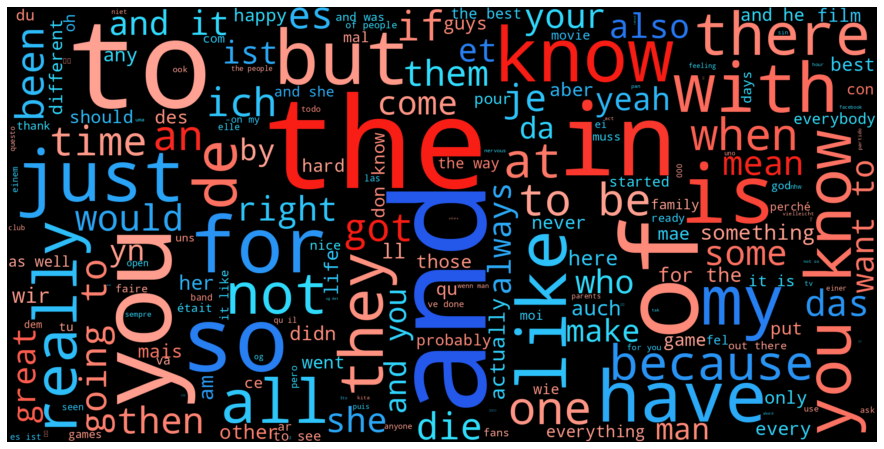

In [17]:
# Define your color range
colors = [Color("#2458EB")]
colors.extend(list(Color("#2458EB").range_to(Color("#31E7FE"), 81))[1:])
colors.extend(list(Color("#31E7FE").range_to(Color("#8da0a2"), 21))[1:])
colors.extend(list(Color("#a18f8c").range_to(Color("#ffad9e"), 21))[1:])
colors.extend(list(Color("#ffad9e").range_to(Color("#d80909"), 81))[1:])
webcolors = [c.get_web() for c in colors]

# Assuming you have a top_model object from DataRobot from which you can get a word cloud object
wc = top_model.get_word_cloud(exclude_stop_words=True)

# Extract the frequency and coefficients of words from the word cloud object, excluding stopwords
dict_freq = {
    wc_word["ngram"]: wc_word["frequency"]
    for wc_word in wc.ngrams
    if not wc_word["is_stopword"]
}
dict_coef = {wc_word["ngram"]: wc_word["coefficient"] for wc_word in wc.ngrams}

# Define the color function using the coefficients


def color_func(word, *args, **kwargs):
    palette_index = int(round(dict_coef[word] * 100)) + 100
    color = webcolors[palette_index]  # This is a hex color string like '#RRGGBB'
    # We split the hex string to get the individual R, G, B components and convert them to integers
    r, g, b = int(color[1:3], 16), int(color[3:5], 16), int(color[5:], 16)
    # Then we format it into an 'rgb(R, G, B)' string that matplotlib expects
    return "rgb({:d}, {:d}, {:d})".format(r, g, b)


# Adjust these parameters to match the desired aesthetics
width = 2000  # Increase width for a wider cloud
height = 1000  # Decrease height relative to width
max_font_size = 300  # Adjust max font size for larger or smaller words

# Create the word cloud image with adjusted parameters
wc_image = WordCloud(
    width=width,
    height=height,
    max_font_size=max_font_size,
    relative_scaling=0.5,
    prefer_horizontal=0.9,  # Set closer to 1 to have more horizontal words
    color_func=color_func,
    background_color="black"  # Adjust if you have a specific background color
    # font_path argument is removed to use the default font
).generate_from_frequencies(dict_freq)

# Display the word cloud image
plt.figure(figsize=(16, 8))  # Adjust figure size to match the aspect ratio of the cloud
plt.imshow(wc_image, interpolation="bilinear")
plt.axis("off")
plt.show()